In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
#from datetime import datetime as dt
# finance module is no longer part of matplotlib
# run: pip install https://github.com/matplotlib/mpl_finance/archive/master.zip
from mpl_finance import candlestick_ohlc as candlestick
from mpl_finance import volume_overlay3
from matplotlib.dates import num2date
from matplotlib.dates import date2num
import matplotlib.mlab as mlab
import datetime


### The following Python libraries are used
>*   numpy 1.14.3
*   pandas 0.23.0
*   matplotlib 2.2.2
*   seaborn 0.8.1
*   scipy 1.1.0
*   statsmodels 0.9.0
*   mpl_finance

### *** About the Data (bitstampUSD) ***
> 1. time_stamp (in unix time)
> 2. volume (BTC) - Volume of BTC transacted 
> 3. price (Currency)- Bitcoin price in Currency units 
> 4. data collected over 21 days starts from 28th September 2018 to 18th October 2018


<font color='black'>
###
====================================================================================================================== <br>
> ** Create tick, volume, and dollar bars. (Bar must have open, high, low, and close values.)  **
    
====================================================================================================================== 

In [2]:
def create_bar(dataframe, column_, units):
    _bars_ = dataframe.copy()
    #print(_bars_)
    if column_ == 'time_stamp':
        _bars_= _bars_.resample(str(units)+'T', label='right').agg({"price":'ohlc',"volume":'sum','transaction':'sum'})
        #print(_bars_)
        _bars_.columns = _bars_.columns.droplevel()
        #print(_bars_)
        _bars_['vwap'] = _bars_['transaction']/_bars_['volume']
        #print(_bars_)
    else:
        if column_ == 'id':
            _bars_[column_] =1
        #print(_bars_)
    
        _bars_['filter'] = _bars_[column_].cumsum()
        #print(_bars_)
        _bars_['group']= 0
        #print(_bars_)
        n = 0
        _bars_['filter'] = _bars_['filter']/units
        #print(_bars_)
        _bars_['filter'] = _bars_['filter'].astype(int)
        #print(_bars_)
        _bars_['group']= _bars_['filter']
        #print(_bars_)
        _bars_ = _bars_.groupby('group').agg({"time_stamp":"last","price":'ohlc',"volume":'sum','transaction':'sum'})
        #print(_bars_)
        
        _bars_.columns = _bars_.columns.droplevel()
        #print(_bars_)
        _bars_['vwap'] = _bars_['transaction']/_bars_['volume']
        #print(_bars_)
        _bars_ = _bars_.set_index('time_stamp')
        #print(_bars_)
    
    return _bars_

In [3]:
def PlotCandlesticks(r):
    candlesticks = zip(date2num(r.time_stamp),r['open'],r['high'],r['low'],r['close'],r['volume'])

    fig = plt.figure()
    #ax1 = plt.subplot2grid((1,1), (0,0))
    fig.set_figheight(15)
    fig.set_figwidth(15)
    ax1 = fig.add_subplot(1,1,1)

    ax1.set_ylabel('Quote ($)', size=20)
    candlestick(ax1, candlesticks,width=.02,colorup='g', colordown='r')

    # shift y-limits of the candlestick plot so that there is space at the bottom for the volume bar chart
    pad = 0.25
    yl = ax1.get_ylim()
    ax1.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])

    # format the x-ticks with a human-readable date. 
    xt = ax1.get_xticks()
    new_xticks = [datetime.date.isoformat(num2date(d)) for d in xt]
    ax1.set_xticklabels(new_xticks,rotation=45, horizontalalignment='right')

    plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90)
    ax1.grid(True)
    plt.ion()
    plt.show()


In [4]:
path = os.getcwd()

In [5]:
data = pd.read_csv(path+'/bitstampUSD_21.csv')
data['transaction'] = data['price'] * data['volume']
data['time_stamp'] = pd.to_datetime(data['time_stamp'])
data.index = data['time_stamp']
data.head()

,time_stamp,price,volume,transaction
time_stamp,,,,
2018-07-28 00:00:06,2018-07-28 00:00:06,8177.72,0.046752,382.321576
2018-07-28 00:00:07,2018-07-28 00:00:07,8182.84,0.023810,194.830884
2018-07-28 00:00:16,2018-07-28 00:00:16,8182.84,0.013163,107.708268
2018-07-28 00:00:16,2018-07-28 00:00:16,8184.35,0.049576,405.750036
2018-07-28 00:00:16,2018-07-28 00:00:16,8184.36,0.047594,389.524302


In [6]:
dollar_bars = create_bar(data, 'transaction', 500000)
dollar_bars.to_csv(path+"/dollar_bars.csv")

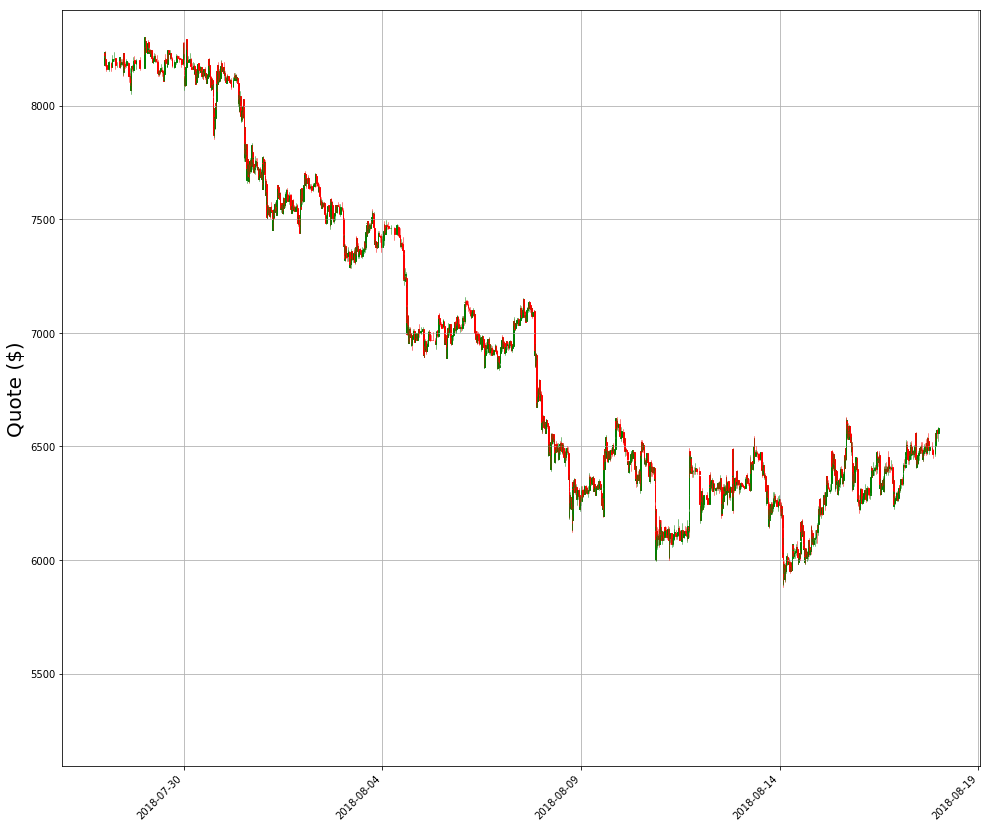

In [7]:
datafile = path+"/dollar_bars.csv"
r = mlab.csv2rec(datafile, delimiter=',')
PlotCandlesticks(r)
#print(r)


<font color='black'>
### 
====================================================================================================================== <br>
> ** 
======================================================================================================================

In [24]:
dollar_bars = create_bar(data, 'transaction', 500000)

#dollar_bars=dollar_bars.assign(dollar_returns=dollar_bars['close'].diff())
#add a column for the returns
dollar_returns_log=np.log(dollar_bars['close']).diff()
dollar_bars=dollar_bars.assign(dollar_returns_log=dollar_returns_log.values)
dollar_bars.head()

KeyError: 'time_stamp'

In [9]:

#add a column for the 20 period std deviation of the log of returns at each bar (volatility)
dollar_bars=dollar_bars.assign(periodVol=dollar_returns_log.ewm(span=50).std())
dollar_bars.head()

,open,high,low,close,volume,transaction,vwap,dollar_returns_log,periodVol
time_stamp,,,,,,,,,
2018-07-28 00:03:28,8177.72,8213.50,8177.72,8213.50,40.711876,334023.790328,8204.578676,NaN,NaN
2018-07-28 00:04:18,8216.74,8234.04,8209.89,8234.04,75.915168,624111.674154,8221.172292,0.002498,NaN
2018-07-28 00:04:49,8232.14,8238.87,8204.96,8221.93,65.823182,541553.725604,8227.401135,-0.001472,0.002807
2018-07-28 00:25:48,8205.03,8217.18,8174.81,8180.20,61.068439,500125.822028,8189.595613,-0.005088,0.003792
2018-07-28 01:08:04,8180.20,8183.49,8152.11,8161.53,58.297761,476165.522835,8167.818390,-0.002285,0.003094


### We define the target as 1 if price moves up more than periodVol value, -1 if price moves up more than periodVol value, and 0 otherwise

In [10]:

dollar_bars=dollar_bars.assign(Target=np.nan)
#create Target column with value 1 if price moves up more than periodVol value, -1 if price moves up more than periodVol value, 
# and 0 otherwise
move_up_bar=dollar_bars[dollar_bars.dollar_returns_log>dollar_bars.periodVol].replace({'Target': np.nan}, 1,inplace=False)
dollar_bars.update(move_up_bar)
move_down_bar=dollar_bars[((dollar_bars.dollar_returns_log*-1)>dollar_bars.periodVol)].replace({'Target': np.nan},-1,inplace=False)
dollar_bars.update(move_down_bar)
dollar_bars=dollar_bars.replace({'Target': np.nan}, 0)
dollar_bars.head()

,open,high,low,close,volume,transaction,vwap,dollar_returns_log,periodVol,Target
time_stamp,,,,,,,,,,
2018-07-28 00:03:28,8177.72,8213.50,8177.72,8213.50,40.711876,334023.790328,8204.578676,NaN,NaN,0.0
2018-07-28 00:04:18,8216.74,8234.04,8209.89,8234.04,75.915168,624111.674154,8221.172292,0.002498,NaN,0.0
2018-07-28 00:04:49,8232.14,8238.87,8204.96,8221.93,65.823182,541553.725604,8227.401135,-0.001472,0.002807,0.0
2018-07-28 00:25:48,8205.03,8217.18,8174.81,8180.20,61.068439,500125.822028,8189.595613,-0.005088,0.003792,-1.0
2018-07-28 01:08:04,8180.20,8183.49,8152.11,8161.53,58.297761,476165.522835,8167.818390,-0.002285,0.003094,0.0


### Adding technical indicators

In [11]:
#Exponential Moving Average  
def EMA(df, n):  
    
    EMA = pd.Series(df['close'].ewm(span=n).mean(), name = 'ema_' + str(n))  
    df = df.join(EMA)  
    return df

#Momentum  
def MOM(df, n):  
    M = pd.Series(df['close'].diff(n), name = 'momentum_' + str(n))  
    df = df.join(M)  
    return df

#Relative Strength Index  
def RSI(df, n):  
    i = 0  
    UpI = [0]  
    DoI = [0]  
    while i  < df['close'].count()-1:
        UpMove = df['high'].iat[i + 1] - df['high'].iat[i]
        DoMove = df['low'].iat[i] - df['low'].iat[i + 1]  
        if UpMove > DoMove and UpMove > 0:  
            UpD = UpMove  
        else: UpD = 0  
        UpI.append(UpD)  
        if DoMove > UpMove and DoMove > 0:  
            DoD = DoMove  
        else: DoD = 0  
        DoI.append(DoD)  
        i = i + 1  
    UpI = pd.Series(UpI)  
    DoI = pd.Series(DoI) 
    
    PosDI = pd.Series(UpI.ewm(span=n,min_periods = n - 1).mean())  
    NegDI = pd.Series(DoI.ewm(span=n,min_periods = n - 1).mean())  
    RSI = pd.Series(PosDI / (PosDI + NegDI), name = 'rsi_' + str(n))  *100
    df = df.assign(RSI=RSI.values)  
    
    return df


#Commodity Channel Index  
def CCI(df, n):  
    
    PP = (df['high'] + df['low'] + df['close']) / 3  
    
    r = PP.rolling(window=n)
    CCI = pd.Series((PP - r.mean()) / r.std(), name = 'CCI_' + str(n))  
    df = df.join(CCI)  
    return df

In [12]:
data = RSI(dollar_bars, 14)
data = MOM(data, 14)
data = CCI(data, 14)
data = EMA(data, 14)


In [13]:
data=data.dropna().drop_duplicates()

In [14]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
transformed_data = pd.DataFrame(data,index = data.index,columns = {'CCI_14','ema_14','RSI','momentum_14','dollar_returns_log','periodVol'})
scaler_data = scaler.fit_transform(transformed_data)
scaler_data = pd.DataFrame(scaler_data, index = transformed_data.index, columns=transformed_data.columns)
scaler_data = scaler_data.assign(Target=data.Target)
scaler_data.head()

,ema_14,CCI_14,momentum_14,dollar_returns_log,RSI,periodVol,Target
time_stamp,,,,,,,
2018-07-28 09:21:33,1.951097,-0.362995,-0.107041,0.755967,0.180266,-0.051154,0.0
2018-07-28 10:08:29,1.951562,0.151314,-0.314003,0.174321,0.632518,-0.261181,0.0
2018-07-28 10:52:15,1.951493,0.368826,-0.192462,-0.055143,0.642873,-0.458099,0.0
2018-07-28 11:10:14,1.947606,-0.607808,0.094552,-0.699155,0.110738,-0.550659,0.0
2018-07-28 11:11:13,1.939597,-1.753203,0.045496,-0.881055,-0.561342,-0.599180,0.0


#### We will shift the values in the Target column up by 1 so that we are actually predicting if a bar is going to have a large move, i.e. Trading signal that is worth taking

In [25]:
#shift the values in the Target column up by 1 so that we are actually predicting if the next bar is going to have a large move
# i.e. A trading signal that is worth taking
scaler_data.Target=scaler_data.Target.shift(-1)
scaler_data = scaler_data[:-1]
scaler_data

,ema_14,CCI_14,momentum_14,dollar_returns_log,RSI,periodVol,Target
time_stamp,,,,,,,
2018-07-28 09:21:33,1.951097,-0.362995,-0.107041,0.755967,0.180266,-0.051154,0.0
2018-07-28 10:08:29,1.951562,0.151314,-0.314003,0.174321,0.632518,-0.261181,0.0
2018-07-28 10:52:15,1.951493,0.368826,-0.192462,-0.055143,0.642873,-0.458099,1.0
2018-07-28 11:10:14,1.947606,-0.607808,0.094552,-0.699155,0.110738,-0.550659,0.0
2018-07-28 11:11:13,1.939597,-1.753203,0.045496,-0.881055,-0.561342,-0.599180,0.0
2018-07-28 11:19:02,1.949457,0.684442,0.677855,3.269537,0.811136,0.945031,0.0
2018-07-28 11:20:40,1.955012,1.326622,0.783533,-0.523896,0.839601,0.785008,0.0
2018-07-28 11:39:33,1.955544,0.586022,0.185343,-0.798081,0.522710,0.680519,0.0
2018-07-28 11:44:04,1.953919,-0.248633,-0.046880,-0.381947,-0.016381,0.510924,-1.0


In [ ]:

features = ['CCI_14','ema_14','RSI','momentum_14','dollar_returns_log','periodVol']
# Separating out the features
x = scaler_data.loc[:, features].values
# Separating out the target
y = scaler_data.loc[:,['Target']].values

#### We will use PCA to see if we can reduce the number of features

In [17]:
from sklearn.decomposition import PCA
# Import different modules for using with the notebook
from IPython.display import display
from IPython.display import Image
from IPython.display import HTML

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
principalDf.head()

,principal component 1,principal component 2
0,-0.294558,-1.475844
1,-0.085082,-1.648974
2,-0.005134,-1.791335
3,-0.851452,-1.593459
4,-1.909142,-1.331024


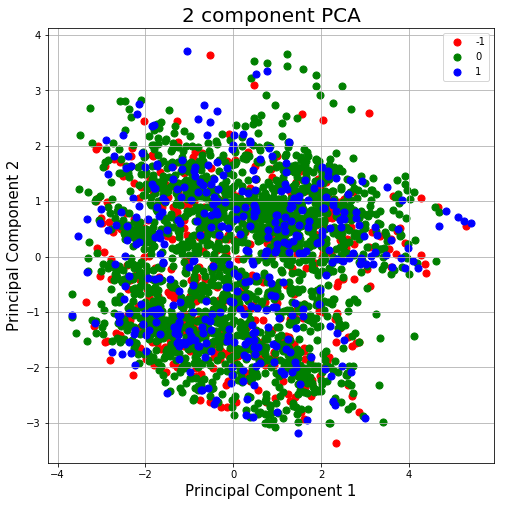

In [18]:
classesDf = pd.DataFrame(data = y, columns = ['Target'])

finalDf = pd.concat([principalDf, classesDf], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [-1,0,1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['Target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


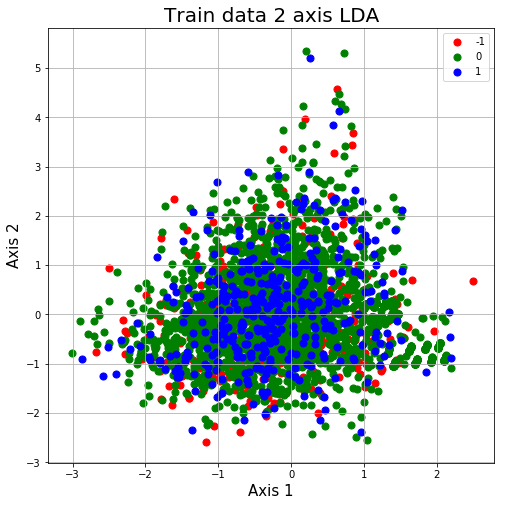

In [19]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
principalComponents = lda.fit_transform(x,y)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])
classesDf = pd.DataFrame(data = y, columns = ['target'])
#print(classesDf)
#print(principalDf)
finalDf = pd.concat([principalDf, classesDf],axis=1)
#print(finalDf)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Axis 1', fontsize = 15)
ax.set_ylabel('Axis 2', fontsize = 15)
ax.set_title('Train data 2 axis LDA', fontsize = 20)
targets = [-1, 0, 1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()


##### * Analysis: There is a lot of overlap in the data using PCA or LDA so we are not going to attempt feature reduction

#### Below we will try to train a model to predict the Target field value (1,0,-1) using a voting classifier that incorporates K-means, SVC and Random Forest learning

In [20]:
from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from collections import Counter

X_train, X_test, y_train, y_test = cross_validation.train_test_split(x, y, test_size=0.25)

clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                        ('knn', neighbors.KNeighborsClassifier()),
                        ('rfor', RandomForestClassifier())])

clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print('accuracy:', confidence)
predictions = clf.predict(X_test)
print('predicted class counts:', Counter(predictions))
#print(y_test)
#print(predictions)

E:\ProgramData\Anaconda3\envs\wqu_ml_fin\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
E:\ProgramData\Anaconda3\envs\wqu_ml_fin\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


accuracy: 0.7090909090909091
predicted class counts: Counter({0.0: 747, -1.0: 20, 1.0: 3})


E:\ProgramData\Anaconda3\envs\wqu_ml_fin\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
E:\ProgramData\Anaconda3\envs\wqu_ml_fin\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


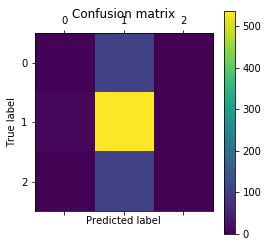

In [21]:
from sklearn.metrics import confusion_matrix
# Plot the confusion matrix.
cm = confusion_matrix(y_test, predictions)
plt.matshow(cm)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Precision, Recall, F-Score

In [22]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predictions, average='macro'))

print(precision_recall_fscore_support(y_test, predictions, average='micro'))

print(precision_recall_fscore_support(y_test, predictions, average='weighted'))


(0.5622936189201249, 0.3503030303030303, 0.3191042357614638, None)
(0.7090909090909091, 0.7090909090909091, 0.7090909090909091, None)
(0.6525339453050296, 0.7090909090909091, 0.6108199781196006, None)


### [To Do] AUC score

In [102]:
from sklearn.metrics import roc_auc_score
#roc_auc_score(y_true=y_test,y_score='TBD')

### [To Do] ROC curves

see doc at https://scikit-learn.org/stable/auto_examples/ensemble/plot_feature_transformation.html#sphx-glr-auto-examples-ensemble-plot-feature-transformation-pyq3d

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<font color='blue'>

   
    
> Analysis:
* 
------------------------------------------------------------------------------------------------------------

<font color='black'>

======================================================================================================================
 ### [To Do] Cross-validation
====================================================================================================================== 


<font color='black'>

======================================================================================================================
 ### [To Do] Fund factsheet using PyFolio 
====================================================================================================================== 
